# Project Stage 01

# COMP5310: Binary Classification Model to Predict Term Deposit Campaign Subscription

## Bank Marketing Data Set
The data is related with direct marketing campaigns of a European Bank. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the product (bank term deposit) would be ('yes') or not ('no') subscribed. 

## Step 1: Reading the bank-additional-full.csv Training Data Set

The `csv` module supports reading and writing of files in comma-separated values (CSV) and similar formats. We use DictReader since the first row of the training data set is a header. This produces a list of dictionaries, one dictionary for all responses. The `pprint` command below prints the dictionary corresponding the the first response.

Note: Make sure that you have uploaded the `bank-additional-full.csv` in the Jupyter Home.

In [1]:
import csv
import pprint
import fileinput

training_set = 'bank-additional-full.csv'

with fileinput.FileInput(training_set, inplace=True) as file:
    for line in file:
        print(line.replace(";", ","), end='')

data_bank_marketing = list(csv.DictReader(open(training_set)))
pprint.pprint(data_bank_marketing[0])

OrderedDict([('age', '56'),
             ('job', 'housemaid'),
             ('marital', 'married'),
             ('education', 'basic.4y'),
             ('default', 'no'),
             ('housing', 'no'),
             ('loan', 'no'),
             ('contact', 'telephone'),
             ('month', 'may'),
             ('day_of_week', 'mon'),
             ('duration', '261'),
             ('campaign', '1'),
             ('pdays', '999'),
             ('previous', '0'),
             ('poutcome', 'nonexistent'),
             ('emp.var.rate', '1.1'),
             ('cons.price.idx', '93.994'),
             ('cons.conf.idx', '-36.4'),
             ('euribor3m', '4.857'),
             ('nr.employed', '5191'),
             ('y', 'no')])


## Step 2: Defining constant for dictionary keys

Before moving on, let's define constants for the keys of this dictionary that will make it a bit easier to use.

In [2]:
AGE = 'age'
JOB = 'job'
MARITAL_STATUS = 'marital'
EDUCATIONAL_ATTAINMENT = 'education'
CREDIT_DEFAULT_FLAG = 'default'
HOUSING_LOAN_FLAG = 'housing'
PERSONAL_LOAN_FLAG = 'loan'
CONTACT_CHANNEL_TYPE = 'contact'
CONTACT_MONTH = 'month'
CONTACT_DAY_OF_WEEK = 'day_of_week'
LAST_CONTACT_DURATION = 'duration'
CAMPAIGN_CONTACTS = 'campaign'
PREVIOUS_CAMPAIGN_LAST_CONTACT = 'pdays'
PREVIOUS_CAMPAIGN_OUTCOME = 'poutcome'
PREVIOUS_CAMPAIGN_CONTACT = 'previous'
QUARTERLY_EMPLOYMENT_VARIATION_RATE = 'emp.var.rate'
MONTHLY_CONSUMER_PRICE_INDEX = 'cons.price.idx'
MONTHLY_CONSUMER_CONFIDENCE_INDEX = 'cons.conf.idx'
DAILY_EURIBOR_3MONTH_RATE = 'euribor3m'
QUARTERLY_NUMBER_OF_EMPLOYEES = 'nr.employed'
CURRENT_OUTCOME = 'y'

## Step 3: Defining connections to AWS Postgres instance `comp5310.cge7dneddtek.ap-southeast-2.rds.amazonaws.com`

First, connection will be establish to the postgresql database.

In [123]:
import psycopg2
import os

try: 
    conn = psycopg2.connect(database='COMP5310', host='comp5310.cge7dneddtek.ap-southeast-2.rds.amazonaws.com',
                            user='epas6415', password='460466466')
    print('Test Connection Successful!')
except Exception as e:
    print("Unable to connect to the database")
    print(e)

Test Connection Successful!


## Step 4: Defining functions to query and execute SQL statements

In [17]:
#Query Function
def pgquery( conn, sqlcmd, args ):
   """ utility function to execute some SQL query statement
       can take optional arguments to fill in (dictionary)
       will print out on screen the result set of the query
       error and transaction handling built-in """
   retval = False
   query_result = []
   with conn:
      with conn.cursor() as cur:
         try:
            if args is None:
                cur.execute(sqlcmd)
            else:
                cur.execute(sqlcmd, args)
            for record in cur:
                query_result.append(record)
            retval = True
         except Exception as e:
            print("DB Read Error: ")
            print(e)
   return query_result

#Execution Function
def pgexec( conn, sqlcmd, args, msg ):
   """ utility function to execute some SQL statement
       can take optional arguments to fill in (dictionary)
       error and transaction handling built-in """
   retval = False
   with conn:
      with conn.cursor() as cur:
         try:
            if args is None:
               cur.execute(sqlcmd)
            else:
               cur.execute(sqlcmd, args)
            if msg is not None:
                print("Success: " + msg)
            retval = True
         except Exception as e:
            print("DB Error: ")
            print(e)
   return retval

## Step 5: Create STG_BANK_TRAINING for Data Ingestion.

The strategy is to load data in the staging table, STG_COMP5310, prior to cleansing and transformation.

In [5]:
staging_bank_training_schema = """CREATE TABLE IF NOT EXISTS STG_BANK_TRAINING
                      (
                      age                VARCHAR(100)
                      ,job               VARCHAR(100)
                      ,marital           VARCHAR(100)
                      ,education         VARCHAR(100)
                      ,default_          VARCHAR(100)
                      ,housing           VARCHAR(100)
                      ,loan              VARCHAR(100)
                      ,contact           VARCHAR(100)
                      ,month_            VARCHAR(100)
                      ,day_of_week       VARCHAR(100)
                      ,duration          VARCHAR(100)
                      ,campaign          VARCHAR(100)
                      ,pdays             VARCHAR(100)
                      ,previous          VARCHAR(100)
                      ,poutcome          VARCHAR(100)
                      ,emp_var_rate      VARCHAR(100)
                      ,cons_price_idx    VARCHAR(100)
                      ,cons_conf_idx     VARCHAR(100)
                      ,euribor3m         VARCHAR(100)
                      ,nr_employed       VARCHAR(100)
                      ,y                 VARCHAR(100)
                      )"""
pgexec (conn, staging_bank_training_schema, None, "Create Table Staging Bank Training")

Success: Create Table Staging Bank Training


True

## Step 6: Delete Data in STG_COMP5310

Perform data cleanup before loading data in the staging.

In [6]:
delete_stmt = """DELETE FROM STG_BANK_TRAINING"""

#Delete Staging Data
pgexec (conn, delete_stmt, None, "Deleted Data Successfully!")


Success: Deleted Data Successfully!


True

## Step 7: Data Ingestion

Open the command prompt and execute the below psql command to import data.

`psql -h comp5310.cge7dneddtek.ap-southeast-2.rds.amazonaws.com -d COMP5310 -U epas6415 -c "\copy stg_bank_training from 'bank-additional-full.csv' with CSV header delimiter as ','"`

Note: Use the password `460466466`

## Step 8: Create Fact and Dimension Tables for Data Model

Create the following Facts and Dimension Tables:
1. FACT_BANK_TRAINING
2. FACT_BANK_TRAINING_KEY
2. DIMN_CAMPAIGN_OUTCOME
3. DIMN_CHANNEL_TYPE
4. DIMN_DAY_WEEK
5. DIMN_EDUCATIONAL_ATTAINMENT
6. DIMN_FLAGS
7. DIMN_JOB
8. DIMN_MARITAL_STATUS
9. DIMN_MONTH

In [36]:
fact_bank_training_schema = """CREATE TABLE IF NOT EXISTS FACT_BANK_TRAINING
                      (
                       RECORD_KEY                          INTEGER
                      ,AGE                                 INTEGER
                      ,AGE_BUCKET                          VARCHAR(50)
                      ,JOB                                 VARCHAR(50)
                      ,MARITAL_STATUS                      VARCHAR(50)
                      ,EDUCATIONAL_ATTAINMENT              VARCHAR(50)
                      ,CREDIT_DEFAULT_FLAG                 VARCHAR(10)
                      ,HOUSING_LOAN_FLAG                   VARCHAR(10)
                      ,PERSONAL_LOAN_FLAG                  VARCHAR(10)
                      ,CONTACT_CHANNEL_TYPE                VARCHAR(50)
                      ,CONTACT_MONTH                       VARCHAR(50)
                      ,CONTACT_DAY_OF_WEEK                 VARCHAR(50)
                      ,LAST_CONTACT_DURATION               INTEGER
                      ,CAMPAIGN_CONTACTS                   INTEGER
                      ,PREVIOUS_CAMPAIGN_LAST_CONTACT      INTEGER
                      ,PREVIOUS_CAMPAIGN_CONTACT           INTEGER
                      ,PREVIOUS_CAMPAIGN_OUTCOME           VARCHAR(20)
                      ,QUARTERLY_EMPLOYMENT_VARIATION_RATE DECIMAL(12,4)
                      ,MONTHLY_CONSUMER_PRICE_INDEX        DECIMAL(12,4)
                      ,MONTHLY_CONSUMER_CONFIDENCE_INDEX   DECIMAL(12,4)
                      ,DAILY_EURIBOR_3MONTH_RATE           DECIMAL(12,4)
                      ,QUARTERLY_NUMBER_OF_EMPLOYEES       DECIMAL(12,4)
                      ,CURRENT_OUTCOME                     VARCHAR(10)
                      )"""

fact_bank_training_key_schema = """CREATE TABLE IF NOT EXISTS FACT_BANK_TRAINING_KEY
                      (
                       AGE                                 INTEGER
                      ,JOB                                 INTEGER
                      ,MARITAL_STATUS                      INTEGER
                      ,EDUCATIONAL_ATTAINMENT              INTEGER
                      ,CREDIT_DEFAULT_FLAG                 INTEGER
                      ,HOUSING_LOAN_FLAG                   INTEGER
                      ,PERSONAL_LOAN_FLAG                  INTEGER
                      ,CONTACT_CHANNEL_TYPE                INTEGER
                      ,CONTACT_MONTH                       INTEGER
                      ,CONTACT_DAY_OF_WEEK                 INTEGER
                      ,LAST_CONTACT_DURATION               INTEGER
                      ,CAMPAIGN_CONTACTS                   INTEGER
                      ,PREVIOUS_CAMPAIGN_LAST_CONTACT      INTEGER
                      ,PREVIOUS_CAMPAIGN_CONTACT           INTEGER
                      ,PREVIOUS_CAMPAIGN_OUTCOME           INTEGER
                      ,QUARTERLY_EMPLOYMENT_VARIATION_RATE DECIMAL(12,4)
                      ,MONTHLY_CONSUMER_PRICE_INDEX        DECIMAL(12,4)
                      ,MONTHLY_CONSUMER_CONFIDENCE_INDEX   DECIMAL(12,4)
                      ,DAILY_EURIBOR_3MONTH_RATE           DECIMAL(12,4)
                      ,QUARTERLY_NUMBER_OF_EMPLOYEES       DECIMAL(12,4)
                      ,CURRENT_OUTCOME                     INTEGER
                      )"""

dimn_campaign_outcome_training_schema = """CREATE TABLE IF NOT EXISTS DIMN_CAMPAIGN_OUTCOME
                      (
                       SOURCE_VALUE                        VARCHAR(50)
                      ,TARGET_KEY                          INTEGER
                      ,TARGET_VALUE                        VARCHAR(50)
                      )"""

dimn_channel_type_schema = """CREATE TABLE IF NOT EXISTS DIMN_CHANNEL_TYPE
                      (
                       SOURCE_VALUE                        VARCHAR(50)
                      ,TARGET_KEY                          INTEGER
                      ,TARGET_VALUE                        VARCHAR(50)
                      )"""

dimn_day_week_schema = """CREATE TABLE IF NOT EXISTS DIMN_DAY_WEEK
                      (
                       SOURCE_VALUE                        VARCHAR(50)
                      ,TARGET_KEY                          INTEGER
                      ,TARGET_VALUE                        VARCHAR(50)
                      )"""

dimn_educ_attain_schema = """CREATE TABLE IF NOT EXISTS DIMN_EDUCATIONAL_ATTAINMENT
                      (
                       SOURCE_VALUE                        VARCHAR(50)
                      ,TARGET_KEY                          INTEGER
                      ,TARGET_VALUE                        VARCHAR(50)
                      )"""

dimn_flags_schema = """CREATE TABLE IF NOT EXISTS DIMN_FLAGS
                      (
                       SOURCE_VALUE                        VARCHAR(50)
                      ,TARGET_KEY                          INTEGER
                      ,TARGET_VALUE                        VARCHAR(50)
                      )"""

dimn_job_schema = """CREATE TABLE IF NOT EXISTS DIMN_JOB
                      (
                       SOURCE_VALUE                        VARCHAR(50)
                      ,TARGET_KEY                          INTEGER
                      ,TARGET_VALUE                        VARCHAR(50)
                      )"""

dimn_marital_status_schema = """CREATE TABLE IF NOT EXISTS DIMN_MARITAL_STATUS
                      (
                       SOURCE_VALUE                        VARCHAR(50)
                      ,TARGET_KEY                          INTEGER
                      ,TARGET_VALUE                        VARCHAR(50)
                      )"""

dimn_month_schema = """CREATE TABLE IF NOT EXISTS DIMN_MONTH
                      (
                       SOURCE_VALUE                        VARCHAR(50)
                      ,TARGET_KEY                          INTEGER
                      ,TARGET_VALUE                        VARCHAR(50)
                      )"""

pgexec (conn, fact_bank_training_schema, None, "Create Table Fact Bank Training")
pgexec (conn, fact_bank_training_key_schema, None, "Create Table Fact Bank Key Training")
pgexec (conn, dimn_campaign_outcome_training_schema, None, "Create Table Campaign Outcome")
pgexec (conn, dimn_channel_type_schema, None, "Create Table Channel Type")
pgexec (conn, dimn_day_week_schema, None, "Create Table Day of the Week")
pgexec (conn, dimn_educ_attain_schema, None, "Create Table Educational Attainment")
pgexec (conn, dimn_flags_schema, None, "Create Table Flags")
pgexec (conn, dimn_job_schema, None, "Create Table Jobs")
pgexec (conn, dimn_marital_status_schema, None, "Create Table Marital Status")
pgexec (conn, dimn_month_schema, None, "Create Table Month")

Success: Create Table Fact Bank Training
Success: Create Table Fact Bank Key Training
Success: Create Table Campaign Outcome
Success: Create Table Channel Type
Success: Create Table Day of the Week
Success: Create Table Educational Attainment
Success: Create Table Flags
Success: Create Table Jobs
Success: Create Table Marital Status
Success: Create Table Month


True

## Step 9: Insert Reference Values into the Dimension Tables

Insert reference values for in the Dimension Tables.

In [18]:
insert_statement = [ "INSERT INTO DIMN_CAMPAIGN_OUTCOME VALUES('success',1,'Success');"
,"INSERT INTO DIMN_CAMPAIGN_OUTCOME VALUES('failure',2,'Failure');"
,"INSERT INTO DIMN_CAMPAIGN_OUTCOME VALUES('nonexistent',3,'Unknown');"
,"INSERT INTO DIMN_CHANNEL_TYPE VALUES('cellular',1,'Cellular');"
,"INSERT INTO DIMN_CHANNEL_TYPE VALUES('telephone',2,'Telephone');"
,"INSERT INTO DIMN_DAY_WEEK VALUES('mon',1,'Monday');"
,"INSERT INTO DIMN_DAY_WEEK VALUES('tue',2,'Tuesday');"
,"INSERT INTO DIMN_DAY_WEEK VALUES('wed',3,'Wednesday');"
,"INSERT INTO DIMN_DAY_WEEK VALUES('thu',4,'Thursday');"
,"INSERT INTO DIMN_DAY_WEEK VALUES('fri',5,'Friday');"
,"INSERT INTO DIMN_DAY_WEEK VALUES('sat',6,'Saturday');"
,"INSERT INTO DIMN_DAY_WEEK VALUES('sun',7,'Sunday');"
,"INSERT INTO DIMN_EDUCATIONAL_ATTAINMENT VALUES('illiterate',1,'Illiterate');"
,"INSERT INTO DIMN_EDUCATIONAL_ATTAINMENT VALUES('basic.4y',2,'Primary First Stage');"
,"INSERT INTO DIMN_EDUCATIONAL_ATTAINMENT VALUES('basic.6y',3,'Primary Second Stage');"
,"INSERT INTO DIMN_EDUCATIONAL_ATTAINMENT VALUES('basic.9y',4,'Middle School');"
,"INSERT INTO DIMN_EDUCATIONAL_ATTAINMENT VALUES('high.school',5,'High School');"
,"INSERT INTO DIMN_EDUCATIONAL_ATTAINMENT VALUES('professional.course',6,'Professional Course');"
,"INSERT INTO DIMN_EDUCATIONAL_ATTAINMENT VALUES('university.degree',7,'University Degree');"
,"INSERT INTO DIMN_EDUCATIONAL_ATTAINMENT VALUES('unknown',8,'Unknown');"
,"INSERT INTO DIMN_FLAGS VALUES('yes',1,'Yes');"
,"INSERT INTO DIMN_FLAGS VALUES('no',2,'No');"
,"INSERT INTO DIMN_FLAGS VALUES('unknown',3,'Unknown');"
,"INSERT INTO DIMN_JOB VALUES('admin.',1,'Administration');"
,"INSERT INTO DIMN_JOB VALUES('blue-collar',2,'Blue Collar');"
,"INSERT INTO DIMN_JOB VALUES('entrepreneur',3,'Entrepreneur');"
,"INSERT INTO DIMN_JOB VALUES('housemaid',4,'Housemaid');"
,"INSERT INTO DIMN_JOB VALUES('management',5,'Management');"
,"INSERT INTO DIMN_JOB VALUES('retired',6,'Retired');"
,"INSERT INTO DIMN_JOB VALUES('self-employed',7,'Self-Employed');"
,"INSERT INTO DIMN_JOB VALUES('services',8,'Services');"
,"INSERT INTO DIMN_JOB VALUES('student',9,'Student');"
,"INSERT INTO DIMN_JOB VALUES('technician',10,'Technician');"
,"INSERT INTO DIMN_JOB VALUES('unemployed',11,'Unemployed');"
,"INSERT INTO DIMN_JOB VALUES('unknown',12,'Unknown');"
,"INSERT INTO DIMN_MARITAL_STATUS VALUES('single',1,'Single');"
,"INSERT INTO DIMN_MARITAL_STATUS VALUES('married',2,'Married');"
,"INSERT INTO DIMN_MARITAL_STATUS VALUES('divorced',3,'Divorced');"
,"INSERT INTO DIMN_MARITAL_STATUS VALUES('unknown',4,'Unknown');"
,"INSERT INTO DIMN_MONTH VALUES('jan',1,'January');"
,"INSERT INTO DIMN_MONTH VALUES('feb',2,'February');"
,"INSERT INTO DIMN_MONTH VALUES('mar',3,'March');"
,"INSERT INTO DIMN_MONTH VALUES('apr',4,'April');"
,"INSERT INTO DIMN_MONTH VALUES('may',5,'May');"
,"INSERT INTO DIMN_MONTH VALUES('jun',6,'June');"
,"INSERT INTO DIMN_MONTH VALUES('jul',7,'July');"
,"INSERT INTO DIMN_MONTH VALUES('aug',8,'August');"
,"INSERT INTO DIMN_MONTH VALUES('sep',9,'September');"
,"INSERT INTO DIMN_MONTH VALUES('oct',10,'October');"
,"INSERT INTO DIMN_MONTH VALUES('nov',11,'November');"
,"INSERT INTO DIMN_MONTH VALUES ('dec',12,'December');"]

for ins_statement in insert_statement:
    pgexec (conn, ins_statement, None, "Inserted Data Successfully!")

Success: Inserted Data Successfully!
Success: Inserted Data Successfully!
Success: Inserted Data Successfully!
Success: Inserted Data Successfully!
Success: Inserted Data Successfully!
Success: Inserted Data Successfully!
Success: Inserted Data Successfully!
Success: Inserted Data Successfully!
Success: Inserted Data Successfully!
Success: Inserted Data Successfully!
Success: Inserted Data Successfully!
Success: Inserted Data Successfully!
Success: Inserted Data Successfully!
Success: Inserted Data Successfully!
Success: Inserted Data Successfully!
Success: Inserted Data Successfully!
Success: Inserted Data Successfully!
Success: Inserted Data Successfully!
Success: Inserted Data Successfully!
Success: Inserted Data Successfully!
Success: Inserted Data Successfully!
Success: Inserted Data Successfully!
Success: Inserted Data Successfully!
Success: Inserted Data Successfully!
Success: Inserted Data Successfully!
Success: Inserted Data Successfully!
Success: Inserted Data Successfully!
S

## Step 10: Perform Data Cleansing and Transformation

In [119]:
delete_stmt = """DELETE FROM FACT_BANK_TRAINING"""

#Delete Staging Data
pgexec (conn, delete_stmt, None, "Deleted Data Successfully!")

insert_statement = """INSERT INTO FACT_BANK_TRAINING 
                           SELECT
                                  ROW_NUMBER() OVER(ORDER BY STG.age) AS RECORD_KEY
                                 ,CAST(STG.age AS INTEGER) AS AGE
                                 ,CASE
                                  WHEN CAST(STG.age AS INTEGER) <= 20 THEN 'Less than 21'
                                  WHEN CAST(STG.age AS INTEGER) BETWEEN 21 AND 30 THEN '21 to 30'
                                  WHEN CAST(STG.age AS INTEGER) BETWEEN 31 AND 40 THEN '31 to 40'
                                  WHEN CAST(STG.age AS INTEGER) BETWEEN 41 AND 50 THEN '41 to 50'
                                  WHEN CAST(STG.age AS INTEGER) BETWEEN 51 AND 60 THEN '51 to 60'
                                  WHEN CAST(STG.age AS INTEGER) BETWEEN 61 AND 70 THEN '61 to 70'
                                  WHEN CAST(STG.age AS INTEGER) BETWEEN 71 AND 80 THEN '71 to 80'
                                  WHEN CAST(STG.age AS INTEGER) > 80 THEN 'More than 80'
                                  END AS AGE
                                 ,JOB.TARGET_VALUE AS JOB
                                 ,MRT.TARGET_VALUE AS  MARITAL_STATUS
                                 ,EDC.TARGET_VALUE AS EDUCATIONAL_ATTAINMENT
                                 ,CRD.TARGET_VALUE AS CREDIT_DEFAULT_FLAG
                                 ,HSE.TARGET_VALUE AS HOUSING_LOAN_FLAG
                                 ,PRL.TARGET_VALUE AS PERSONAL_LOAN_FLAG
                                 ,CHN.TARGET_VALUE AS CONTACT_CHANNEL_TYPE
                                 ,MNT.TARGET_VALUE AS CONTACT_MONTH
                                 ,DWK.TARGET_VALUE AS CONTACT_DAY_OF_WEEK
                                 ,CAST(STG.duration AS INTEGER) AS LAST_CONTACT_DURATION
                                 ,CAST(STG.campaign AS INTEGER) AS CAMPAIGN_CONTACTS
                                 ,CASE
                                  WHEN STG.pdays = '999' THEN 0
                                  ELSE CAST(STG.pdays AS INTEGER)
                                  END                                       AS PREVIOUS_CAMPAIGN_LAST_CONTACT
                                 ,CAST(STG.previous AS INTEGER)             AS PREVIOUS_CAMPAIGN_CONTACT
                                 ,OTC.TARGET_VALUE AS PREVIOUS_CAMPAIGN_OUTCOME
                                 ,CAST(STG.emp_var_rate AS DECIMAL(12,4))   AS QUARTERLY_EMPLOYMENT_VARIATION_RATE
                                 ,CAST(STG.cons_price_idx AS DECIMAL(12,4)) AS MONTHLY_CONSUMER_PRICE_INDEX
                                 ,CAST(STG.cons_conf_idx AS DECIMAL(12,4))  AS MONTHLY_CONSUMER_CONFIDENCE_INDEX
                                 ,CAST(STG.euribor3m AS DECIMAL(12,4))      AS DAILY_EURIBOR_3MONTH_RATE
                                 ,CAST(STG.nr_employed AS DECIMAL(12,4))    AS QUARTERLY_NUMBER_OF_EMPLOYEES
                                 ,FNL.TARGET_VALUE                    AS CURRENT_OUTCOME
                             FROM STG_BANK_TRAINING STG
                       INNER JOIN DIMN_JOB JOB
                               ON STG.JOB       = JOB.SOURCE_VALUE                     
                       INNER JOIN DIMN_MARITAL_STATUS MRT
                               ON STG.marital = MRT.SOURCE_VALUE
                       INNER JOIN DIMN_EDUCATIONAL_ATTAINMENT EDC
                               ON STG.education = EDC.SOURCE_VALUE
                       INNER JOIN DIMN_FLAGS CRD
                               ON STG.default_ = CRD.SOURCE_VALUE
                       INNER JOIN DIMN_FLAGS HSE
                               ON STG.housing = HSE.SOURCE_VALUE
                       INNER JOIN DIMN_FLAGS PRL
                               ON STG.loan = PRL.SOURCE_VALUE
                       INNER JOIN DIMN_CHANNEL_TYPE CHN
                               ON STG.contact = CHN.SOURCE_VALUE
                       INNER JOIN DIMN_MONTH MNT
                               ON STG.month_ = MNT.SOURCE_VALUE
                       INNER JOIN DIMN_DAY_WEEK DWK
                               ON STG.day_of_week = DWK.SOURCE_VALUE
                       INNER JOIN DIMN_CAMPAIGN_OUTCOME OTC
                               ON STG.poutcome = OTC.SOURCE_VALUE
                       INNER JOIN DIMN_FLAGS FNL
                               ON STG.y = FNL.SOURCE_VALUE
                       """

#Insert Data into the Fact Table
pgexec (conn, insert_statement, None, "Inserted Data Successfully!")

delete_stmt = """DELETE FROM FACT_BANK_TRAINING_KEY"""

#Delete Staging Data
pgexec (conn, delete_stmt, None, "Deleted Data Successfully!")

insert_statement = """INSERT INTO FACT_BANK_TRAINING_KEY
                           SELECT
                                  CAST(STG.age AS INTEGER) AS AGE
                                 ,JOB.TARGET_KEY AS JOB
                                 ,MRT.TARGET_KEY AS  MARITAL_STATUS
                                 ,EDC.TARGET_KEY AS EDUCATIONAL_ATTAINMENT
                                 ,CRD.TARGET_KEY AS CREDIT_DEFAULT_FLAG
                                 ,HSE.TARGET_KEY AS HOUSING_LOAN_FLAG
                                 ,PRL.TARGET_KEY AS PERSONAL_LOAN_FLAG
                                 ,CHN.TARGET_KEY AS CONTACT_CHANNEL_TYPE
                                 ,MNT.TARGET_KEY AS CONTACT_MONTH
                                 ,DWK.TARGET_KEY AS CONTACT_DAY_OF_WEEK
                                 ,CAST(STG.duration AS INTEGER) AS LAST_CONTACT_DURATION
                                 ,CAST(STG.campaign AS INTEGER) AS CAMPAIGN_CONTACTS
                                 ,CASE
                                  WHEN STG.pdays = '999' THEN 0
                                  ELSE CAST(STG.pdays AS INTEGER)
                                  END                                       AS PREVIOUS_CAMPAIGN_LAST_CONTACT
                                 ,CAST(STG.previous AS INTEGER)             AS PREVIOUS_CAMPAIGN_CONTACT
                                 ,OTC.TARGET_KEY AS PREVIOUS_CAMPAIGN_OUTCOME
                                 ,CAST(STG.emp_var_rate AS DECIMAL(12,4))   AS QUARTERLY_EMPLOYMENT_VARIATION_RATE
                                 ,CAST(STG.cons_price_idx AS DECIMAL(12,4)) AS MONTHLY_CONSUMER_PRICE_INDEX
                                 ,CAST(STG.cons_conf_idx AS DECIMAL(12,4))  AS MONTHLY_CONSUMER_CONFIDENCE_INDEX
                                 ,CAST(STG.euribor3m AS DECIMAL(12,4))      AS DAILY_EURIBOR_3MONTH_RATE
                                 ,CAST(STG.nr_employed AS DECIMAL(12,4))    AS QUARTERLY_NUMBER_OF_EMPLOYEES
                                 ,FNL.TARGET_KEY                    AS CURRENT_OUTCOME
                             FROM STG_BANK_TRAINING STG
                       INNER JOIN DIMN_JOB JOB
                               ON STG.JOB       = JOB.SOURCE_VALUE                     
                       INNER JOIN DIMN_MARITAL_STATUS MRT
                               ON STG.marital = MRT.SOURCE_VALUE
                       INNER JOIN DIMN_EDUCATIONAL_ATTAINMENT EDC
                               ON STG.education = EDC.SOURCE_VALUE
                       INNER JOIN DIMN_FLAGS CRD
                               ON STG.default_ = CRD.SOURCE_VALUE
                       INNER JOIN DIMN_FLAGS HSE
                               ON STG.housing = HSE.SOURCE_VALUE
                       INNER JOIN DIMN_FLAGS PRL
                               ON STG.loan = PRL.SOURCE_VALUE
                       INNER JOIN DIMN_CHANNEL_TYPE CHN
                               ON STG.contact = CHN.SOURCE_VALUE
                       INNER JOIN DIMN_MONTH MNT
                               ON STG.month_ = MNT.SOURCE_VALUE
                       INNER JOIN DIMN_DAY_WEEK DWK
                               ON STG.day_of_week = DWK.SOURCE_VALUE
                       INNER JOIN DIMN_CAMPAIGN_OUTCOME OTC
                               ON STG.poutcome = OTC.SOURCE_VALUE
                       INNER JOIN DIMN_FLAGS FNL
                               ON STG.y = FNL.SOURCE_VALUE
                       """

#Insert Data into the Fact Table with Keys Only
pgexec (conn, insert_statement, None, "Inserted Data Successfully!")

Success: Deleted Data Successfully!
Success: Inserted Data Successfully!
Success: Deleted Data Successfully!
Success: Inserted Data Successfully!


True

## Step 11: Download data for visualisation using Tableau 10.2 Student Edition
Open the command prompt and execute the below psql command to import data.

`psql -h comp5310.cge7dneddtek.ap-southeast-2.rds.amazonaws.com -d COMP5310 -U epas6415 -c "\copy fact_bank_training to 'fact_bank_training.csv' with CSV header delimiter as ','"`

Note: Use the password `460466466`

## Step 12.1: Descriptive Statistical Calculations
Calculation basic statistical calculations.

Age
Mode: 31
Mean: 40.02
Median: 38.00
Standard deviation: 10.42


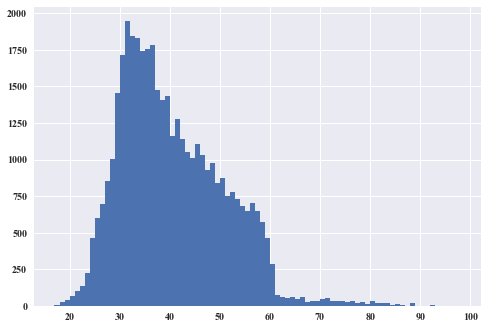



Age Bucket
Mode: 31 to 40


Job
Mode: Administration


Marital Status
Mode: Married


Educational Attainment
Mode: University Degree


Credit Default Flag
Mode: No


Housing Loan Flag
Mode: Yes


Personal Loan Flag
Mode: No


Contact Channel Type
Mode: Cellular


Contact Month
Mode: May


Contact Day of Week
Mode: Thursday


Last Contact Duration
Mode: 85
Mean: 258.29
Median: 180.00
Standard deviation: 259.28


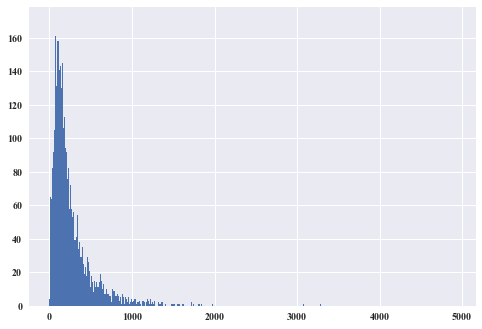



Campaign Contacts
Mode: 1
Mean: 2.57
Median: 2.00
Standard deviation: 2.77


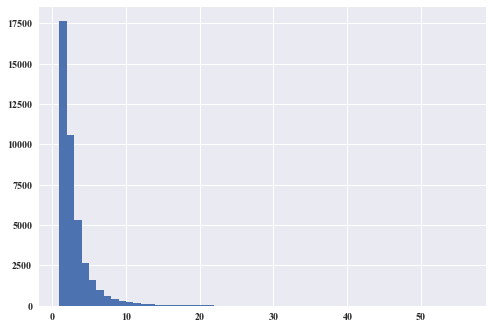



Previous Campaign Last Contact
Mode: 0
Mean: 0.22
Median: 0.00
Standard deviation: 1.35


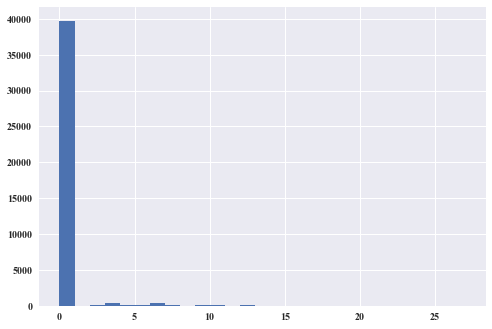



Previous Campaign Contact
Mode: 0
Mean: 0.17
Median: 0.00
Standard deviation: 0.49


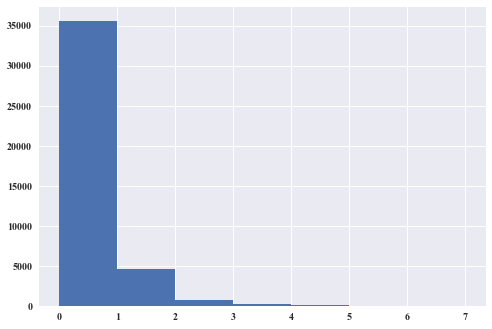



Previous Campaign Outcome
Mode: Unknown


Campaign Outcome
Mode: No




In [144]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
from collections import Counter

def mode(mode_data, column_key):
    c = Counter([row[column_key] for row in mode_data])
    return c.most_common(1)[0][0]

def is_float(input):
  try:
    num = float(input)
  except ValueError:
    return False
  return True

def is_int(input):
  try:
    num = int(input)
  except ValueError:
    return False
  return True

key = [ 'Record Key'
       ,'Age'
       ,'Age Bucket'
       ,'Job'
       ,'Marital Status'
       ,'Educational Attainment'
       ,'Credit Default Flag'
       ,'Housing Loan Flag'
       ,'Personal Loan Flag'
       ,'Contact Channel Type'
       ,'Contact Month'
       ,'Contact Day of Week'
       ,'Last Contact Duration'
       ,'Campaign Contacts'
       ,'Previous Campaign Last Contact'
       ,'Previous Campaign Contact'
       ,'Previous Campaign Outcome'
       ,'Quarterly Employment Variation Rate'
       ,'Monthly Consumer Price Index'
       ,'Monthly Consumer Confidence Index'
       ,'Daily Euribor 3Month Rat'
       ,'Quarterly Number of Employees'
       ,'Campaign Outcome']
 
#Select Data from FACT_BANK_TRAINING_KEY
query_stmt = "SELECT * FROM FACT_BANK_TRAINING;"

#Execute Query Statement
data = pgquery (conn, query_stmt, None)

new_data = []
for row in data:
    new_data.append(dict(zip(key, row)))

key = [ 'Age'
       ,'Age Bucket'
       ,'Job'
       ,'Marital Status'
       ,'Educational Attainment'
       ,'Credit Default Flag'
       ,'Housing Loan Flag'
       ,'Personal Loan Flag'
       ,'Contact Channel Type'
       ,'Contact Month'
       ,'Contact Day of Week'
       ,'Last Contact Duration'
       ,'Campaign Contacts'
       ,'Previous Campaign Last Contact'
       ,'Previous Campaign Contact'
       ,'Previous Campaign Outcome'
       ,'Campaign Outcome']

#Bin Width
binwidth = 1

for column_key in key:
    v = [row[column_key] for row in new_data] # grab values
    print(column_key)
    print("Mode:", mode(new_data, column_key))
    if is_float(v[0]) or is_int(v[0]):
        v = list(map(int, v))
        print("Mean: {:.2f}".format(np.nanmean(v)))
        print("Median: {:.2f}".format(np.nanmedian(v)))
        print("Standard deviation: {:.2f}".format(np.nanstd(v)))
        plt.hist(v,bins=range(min(v), max(v) + binwidth, binwidth))
        plt.show()
    print('\n')
   

## Step 12.2: Calculate Correlation Coefficient between Attributes

Using Pearson Correlation Method, correlation coefficient between each attribute will calculated.

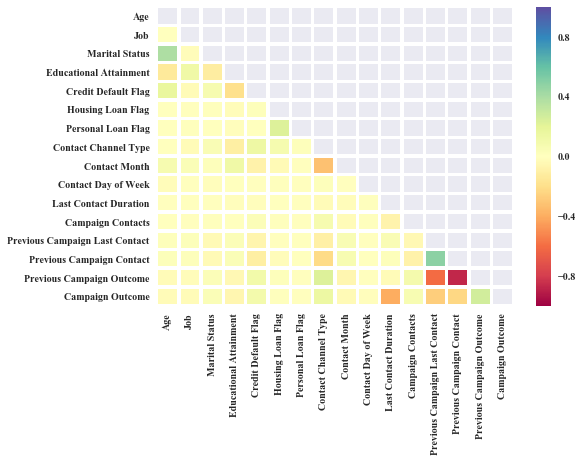

In [125]:
from matplotlib import font_manager 

#Set Default Font to Times New Roman
font_manager.findfont('Times New Roman')
plt.rc('font', family='serif') 
plt.rc('font', serif='Times New Roman') 

#Data Frame Columns
df_column = [ 'Age'
             ,'Job'
             ,'Marital Status'
             ,'Educational Attainment'
             ,'Credit Default Flag'
             ,'Housing Loan Flag'
             ,'Personal Loan Flag'
             ,'Contact Channel Type'
             ,'Contact Month'
             ,'Contact Day of Week'
             ,'Last Contact Duration'
             ,'Campaign Contacts'
             ,'Previous Campaign Last Contact'
             ,'Previous Campaign Contact'
             ,'Previous Campaign Outcome'
             ,'Quarterly Employment Variation Rate'
             ,'Monthly Consumer Price Index'
             ,'Monthly Consumer Confidence Index'
             ,'Daily Euribor 3Month Rat'
             ,'Quarterly Number of Employees'
             ,'Campaign Outcome']

#Select Data from FACT_BANK_TRAINING_KEY
query_stmt = "SELECT * FROM FACT_BANK_TRAINING_KEY"

#Execute Query Statement
data = pgquery (conn, query_stmt, None)

#Generate Data Frame
df = pd.DataFrame(data, columns=df_column)

#Generate Correlation Coefficient
corr_df = df.corr(method='pearson')

#Generate Heatmap
# Create a mask to display only the lower triangle of the matrix (since it's mirrored around its
# top-left to bottom-right diagonal).
mask = np.zeros_like(corr_df)
mask[np.triu_indices_from(mask)] = True
# Create the heatmap using seaborn library.
# List if colormaps (parameter 'cmap') is available here: http://matplotlib.org/examples/color/colormaps_reference.html
seaborn.heatmap(corr_df, cmap='Spectral', vmax=1.0, vmin=-1.0, mask=mask, linewidths=2.5)

# Show the plot we reorient the labels for each column and row to make them easier to read.


plt.yticks(rotation=0)
plt.xticks(rotation=90)
plt.show()